# Appendix. Feature Engineering

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
from helper_functions import preprocessing
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif, f_regression


custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.figsize": (15, 10),
    "figure.autolayout": True,
    "axes.titlesize": "large",  
    "patch.edgecolor": "w",
    "patch.linewidth": 0.5,
}
sns.set_theme(style="whitegrid", rc=custom_params)
pd.set_option("display.max_rows", 200)
pd.set_option("display.precision", 2,"display.max_colwidth", None)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
dataset_file = "./data/database.sqlite"
conn = sqlite3.connect(dataset_file)

## Feature Creation

This appendix part deals with table merging and data manipulation to obtain possible relevant features. Relevant team and player attributes as well as match information first are read. It is important that they are ordered by time. For team attributes, numerical features are kept instead of categorical. For player attributes, only general attribute, such as overall_rating, is considered. Regarding match information, player ids and their Y positions are kept to obtain overall team attributes calculated from player attributes and team formations for the game.

In [3]:
query = """
        SELECT team_api_id team_id, date, chanceCreationPassing,
               chanceCreationCrossing, chanceCreationShooting,
               defencePressure, defenceAggression
          FROM Team_attributes
         ORDER BY date, team_api_id 
        """
team_att = pd.read_sql(query, conn)
team_att = preprocessing.optimize_dtypes(team_att)

query = """
        SELECT player_api_id player_id, date, overall_rating
          FROM Player_attributes
         WHERE overall_rating IS NOT NULL          
         ORDER BY date, player_api_id 
        """
player_att = pd.read_sql(query, conn)
player_att = preprocessing.optimize_dtypes(player_att)

query = """
        SELECT  m.match_api_id match_id,
                l.name League, m.season Season, m.stage, m.date,
                m.home_team_api_id home_team_id, m.away_team_api_id away_team_id,
                m.home_team_goal home_goal, m.away_team_goal away_goal,
                m.home_player_Y1, m.home_player_Y2, m.home_player_Y3, 
                m.home_player_Y4, m.home_player_Y5, m.home_player_Y6, 
                m.home_player_Y7, m.home_player_Y8, m.home_player_Y9, 
                m.home_player_Y10, m.home_player_Y11, 
                m.away_player_Y1, m.away_player_Y2, m.away_player_Y3, 
                m.away_player_Y4, m.away_player_Y5, m.away_player_Y6, 
                m.away_player_Y7, m.away_player_Y8, m.away_player_Y9, 
                m.away_player_Y10, m.away_player_Y11,                
                m.home_player_1, m.home_player_2, m.home_player_3, 
                m.home_player_4, m.home_player_5, m.home_player_6, 
                m.home_player_7, m.home_player_8, m.home_player_9, 
                m.home_player_10, m.home_player_11, 
                m.away_player_1, m.away_player_2, m.away_player_3, 
                m.away_player_4, m.away_player_5, m.away_player_6, 
                m.away_player_7, m.away_player_8, m.away_player_9, 
                m.away_player_10, m.away_player_11,
                CASE
                    WHEN m.home_team_goal > m.away_team_goal THEN 'Home Win'
                    WHEN m.home_team_goal < m.away_team_goal THEN 'Away Win'
                    ELSE 'Draw'
                END AS Result                
          FROM Match m
          LEFT JOIN League l ON m.league_id = l.id     
         ORDER BY m.date
        """
match_info = pd.read_sql(query, conn)
match_info.fillna(0, inplace=True)  # so that merge can be performed
match_info = preprocessing.optimize_dtypes(match_info)

In [4]:
print(f"Earliest team attribute update: {team_att['date'].min()}")

Earliest team attribute update: 2010-02-22 00:00:00


Latest team attributes are merged with match information. However, the oldest attribute can be up to 2-years-old.

In [5]:
merge_tolerance_days = 731  # max 2yrs-old attributes allowed
match = pd.merge_asof(
    left=match_info,
    right=team_att,
    on="date",
    left_by="home_team_id",
    right_by="team_id",
    direction="backward",
    tolerance=pd.Timedelta(days=merge_tolerance_days),
)
match.drop(columns="team_id", inplace=True)
match = pd.merge_asof(
    left=match,
    right=team_att,
    on="date",
    left_by="away_team_id",
    right_by="team_id",
    suffixes=["_home", "_away"],
    direction="backward",
    tolerance=pd.Timedelta(days=merge_tolerance_days),
)
match.drop(columns="team_id", inplace=True)

Latest player attributes are merged with match information.

In [6]:
player_cols = match.filter(regex="_player_\d", axis=1).columns.tolist()
for col in player_cols:
    match = pd.merge_asof(
        left=match,
        right=player_att,
        on="date",
        left_by=col,
        right_by="player_id",
        direction="backward",
        tolerance=pd.Timedelta(days=merge_tolerance_days),
    )
    for att in ["overall_rating"]:
        match.rename(
            columns={f"{att}": f"{att}_{col[0:4]}_p{col[12:]}"}, inplace=True
        )
    match.drop(columns="player_id", inplace=True)
match.drop(columns=player_cols, inplace=True)

Formations are obtained for each team.

In [7]:
def get_formation(row):
    """x-x-x formation, where positions 2-4 correspond with defenders,
    5-8 correspond with midfielders, and 9-11 correspond with forwards."""
    positions = row.tolist()
    counts = Counter(positions)
    if (0 in positions) or (counts[1] > 1):
        return None
    else:
        defenders = counts[2] + counts[3] + counts[4]
        midfielders = counts[5] + counts[6] + counts[7] + counts[8]
        forwards = counts[9] + counts[10] + counts[11]
        return f"{defenders}-{midfielders}-{forwards}"


for team in ["home", "away"]:
    form_cols = match.filter(like=f"{team}_player_Y", axis=1).columns.tolist()
    match[f"formation_{team}"] = match[form_cols].apply(get_formation, axis=1)
    match.drop(columns=form_cols, inplace=True)

Overall rating is calculated for each team based on player attributes.

In [8]:
def mean_attribute(row):
    """Mean team attribute estimated from at least 7 team players."""
    if row.isna().sum() > 4:
        return None
    else:
        return row.mean()


for team in ["home", "away"]:
    for att in ["overall_rating"]:
        att_cols = match.filter(
            like=f"{att}_{team}_p", axis=1
        ).columns.tolist()
        match[f"{att}_{team}"] = match[att_cols].apply(mean_attribute, axis=1)
        match.drop(columns=att_cols, inplace=True)
match = preprocessing.optimize_dtypes(match)
match_copy = match.copy()

Columns with goal difference (GD) and points received for each match for home and away team are created. Also, a helper column with a maximum possible points (3) is created.

In [9]:
def get_points(x):
    """Points for the game."""
    if x > 0:
        return 3
    elif x == 0:
        return 1
    else:
        return 0


match["GD_home"] = (match["home_goal"] - match["away_goal"]).astype("int8")
match["GD_away"] = (match["away_goal"] - match["home_goal"]).astype("int8")
match["points_home"] = match["GD_home"].apply(get_points)
match["points_away"] = match["GD_away"].apply(get_points)
match["points_max"] = 3

Team information table is created for each team with points, proportion of maximum available points, GD, number of scored and conceded goals within a season before each played match.

In [10]:
def get_melted_df(value_vars, value_name):
    melted_df = pd.melt(
        match,
        id_vars=[
            "match_id",
            "Season",
            "date",
            "points_max",
            "home_team_id",
            "away_team_id",
        ],
        value_vars=value_vars,
        var_name="team_id",
        value_name=value_name,
    )
    melted_df["team_id"] = melted_df.apply(
        lambda row: row["home_team_id"]
        if row["team_id"] == value_vars[0]
        else row["away_team_id"],
        axis=1,
    )
    melted_df.drop(columns=["home_team_id", "away_team_id"], inplace=True)
    return melted_df


def get_season_sum(df, col, fill_value=0):
    s = df.groupby(by=["team_id", "Season"])[col].transform(
        lambda x: x.expanding().sum().shift(fill_value=fill_value)
    )
    return s


def get_season_avg(df, col, fill_value=0):
    s = df.groupby(by=["team_id", "Season"])[col].transform(
        lambda x: x.expanding().mean().shift(fill_value=fill_value)
    )
    return s


scored_df = get_melted_df(
    value_vars=["home_goal", "away_goal"], value_name="scored"
)
conceded_df = get_melted_df(
    value_vars=["away_goal", "home_goal"], value_name="conceded"
)
points_df = get_melted_df(
    value_vars=["points_home", "points_away"], value_name="points"
)
GD_df = get_melted_df(value_vars=["GD_home", "GD_away"], value_name="GD")
on_keys = ["match_id", "Season", "date", "team_id", "points_max"]
team_info = pd.merge(left=scored_df, right=conceded_df, on=on_keys)
team_info = team_info.merge(points_df, on=on_keys)
team_info = team_info.merge(GD_df, on=on_keys)
team_info.sort_values(by=["date"], inplace=True)
team_info["season_points"] = get_season_sum(team_info, "points")
team_info["season_points_max"] = get_season_sum(
    team_info, "points_max", fill_value=3
)
team_info["season_points_max"] = (
    team_info["season_points"] / team_info["season_points_max"]
)
team_info["season_GD"] = get_season_sum(team_info, "GD")
team_info["season_scored"] = get_season_sum(team_info, "scored")
team_info["season_conceded"] = get_season_sum(team_info, "conceded")
team_info["season_scored_avg"] = get_season_avg(team_info, "scored")
team_info["season_conceded_avg"] = get_season_avg(team_info, "conceded")
team_info.drop(
    columns=[
        "points",
        "GD",
        "scored",
        "conceded",
        "points_max",
        "season_points",
    ],
    inplace=True,
)
# team_info[team_info["team_id"] == 9874].head(50)

This team information table is merged with match table so that generated attributes could be used for match result prediction.

In [11]:
match = match_copy
match = match.merge(
    right=team_info,
    left_on=["match_id", "Season", "date", "home_team_id"],
    right_on=["match_id", "Season", "date", "team_id"],
)
match.drop(columns=["team_id"], inplace=True)
match = match.merge(
    right=team_info,
    left_on=["match_id", "Season", "date", "away_team_id"],
    right_on=["match_id", "Season", "date", "team_id"],
    suffixes=("_home", "_away"),
)
match.drop(columns=["team_id"], inplace=True)

To represent teams ability to score and defend playing home and away, rolling 5-match average number of goals scored and conceded home and away are obtained.

In [12]:
def get_rolling_avg(df, group, col):
    s = df.groupby(by=group)[col].transform(
        lambda x: x.rolling(5, min_periods=1).mean().shift()
    )
    return s


match["scored_roll_avg_home"] = get_rolling_avg(
    match, "home_team_id", "home_goal"
)
match["conceded_roll_avg_home"] = get_rolling_avg(
    match, "home_team_id", "away_goal"
)
match["scored_roll_avg_away"] = get_rolling_avg(
    match, "away_team_id", "away_goal"
)
match["conceded_roll_avg_away"] = get_rolling_avg(
    match, "away_team_id", "home_goal"
)

Proportion of win/draw/loss of previous home matches played by home team as well as proportion of win/draw/loss of previous away matches played by away team are calculated using exponentially weighted mean to put more emphasis on more current matches.

In [13]:
def get_ewm_avg(df, group, col):
    s = df.groupby(by=group)[col].transform(
        lambda x: x.ewm(alpha=0.1).mean().shift()
    )
    return s


match["_"] = match["Result"]
match = pd.get_dummies(match, columns=["_"], prefix="")
match["win_prop_home"] = get_ewm_avg(match, "home_team_id", "_Home Win")
match["draw_prop_home"] = get_ewm_avg(match, "home_team_id", "_Draw")
match["loss_prop_home"] = get_ewm_avg(match, "home_team_id", "_Away Win")
match["win_prop_away"] = get_ewm_avg(match, "away_team_id", "_Away Win")
match["draw_prop_away"] = get_ewm_avg(match, "away_team_id", "_Draw")
match["loss_prop_away"] = get_ewm_avg(match, "away_team_id", "_Home Win")
# match.loc[match["home_team_id"] == 9874].head(50)

Differences of some features are obtained as additional featrues.

In [14]:
match["season_GD_diff"] = match["season_GD_home"] - match["season_GD_away"]
match["season_scored_diff"] = (
    match["season_scored_home"] - match["season_scored_away"]
)
match["season_conceded_diff"] = (
    match["season_conceded_home"] - match["season_conceded_away"]
)
match["season_points_max_diff"] = (
    match["season_points_max_home"] - match["season_points_max_away"]
)
match["overall_rating_diff"] = (
    match["overall_rating_home"] - match["overall_rating_away"]
)

Finally, some columns are remove as unnecessary for modeling tasks.

In [15]:
match.drop(
    columns=[
        "_Away Win",
        "_Draw",
        "_Home Win",
        "home_team_id",
        "away_team_id",
        "stage",
        "match_id",
    ],
    inplace=True,
)

## Initial Feature Selection

This appendix part deals with initial feature selection to reduce dataframe for the main modeling tasks. 

Seasons 2008/2009 and 2009/2010 have all attributes available for none or a third of matches. This is related to the fact that team attribute data is only available since February 22, 2010. Only leagues of England, France, Germany, Italy, and Spain have all attributes available for almost all matches in seasons from 2010/2011 to 2015/2016. Therefore, initial features are selected using data from only five major leagues. The latest season is holdout for testing, and the first two seasons are removed since team attributes are mostly missing in those two seasons.

In [16]:
missing_data_counts = (
    match.groupby(["League", "Season"])
    .apply(lambda x: x.isna().any(axis=1).sum())
    .unstack()
)
total_rows = match.groupby(["League", "Season"]).size().unstack()
available_data_percentage = (
    (total_rows - missing_data_counts) / total_rows * 100
)
print("Proportion of Rows with All Data Available:")
display(
    available_data_percentage.style.background_gradient(
        cmap="Blues", axis=None, vmax=100
    ).format("{:.1f}%")
)

Proportion of Rows with All Data Available:


Season,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
League,,,,,,,,
Belgium Jupiler League,0.0%,13.3%,77.5%,79.2%,86.7%,50.0%,72.9%,81.7%
England Premier League,0.0%,30.5%,99.5%,98.4%,98.9%,98.9%,99.5%,98.9%
France Ligue 1,0.0%,34.7%,98.9%,98.4%,98.7%,99.5%,98.7%,98.9%
Germany 1. Bundesliga,0.0%,32.4%,98.4%,99.3%,98.7%,99.3%,99.3%,98.4%
Italy Serie A,0.0%,34.7%,98.9%,99.4%,99.2%,98.9%,99.5%,98.9%
Netherlands Eredivisie,0.0%,29.4%,84.6%,98.0%,85.0%,76.8%,75.8%,87.9%
Poland Ekstraklasa,0.0%,0.0%,0.0%,0.0%,0.0%,67.9%,69.2%,73.3%
Portugal Liga ZON Sagres,0.0%,33.8%,79.2%,79.6%,75.4%,73.8%,74.8%,77.8%
Scotland Premier League,0.0%,33.3%,88.6%,88.2%,68.0%,81.1%,80.7%,97.8%


In [17]:
data = match.copy()
data.drop(
    data[data["Season"].isin(["2008/2009", "2009/2010"])].index,
    inplace=True,
)
data["Season"] = data["Season"].cat.remove_unused_categories()
data.drop(
    data[
        ~data["League"].str.contains(
            "England|France|Germany|Italy|Spain", regex=True
        )
    ].index,
    inplace=True,
)
data["League"] = data["League"].cat.remove_unused_categories()
data.drop(
    columns=["date"],
    inplace=True,
)
data_train = data[~data["Season"].isin(["2015/2016"])].copy()
X_train = data_train.drop(
    columns=["Result", "home_goal", "away_goal", "Season"]
)
Y_train_win = data_train["Result"]
Y_train_home_goal = data_train["home_goal"]
Y_train_away_goal = data_train["away_goal"]

Correlation matrix show that some engineered features are highly correlated with each other (more than 0.8 absolute correlation coefficient), and thus, appropriate selection should be implemented to prevent multicollinearity and and align with the modeling assumption of the independent features. 

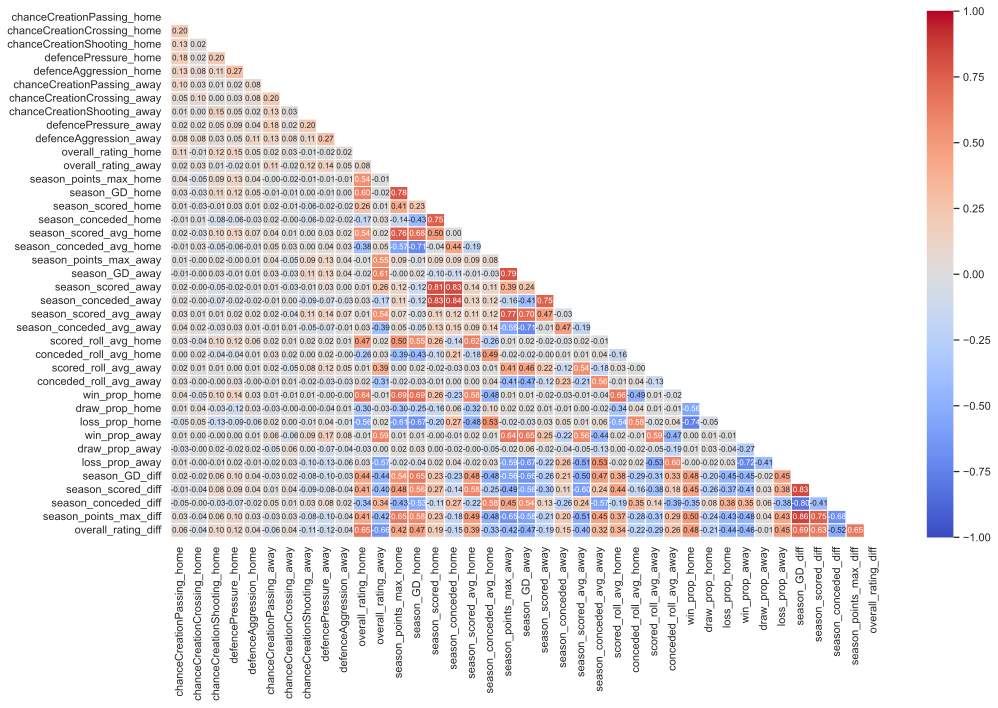

In [18]:
corr_matrix = X_train.corr("spearman", numeric_only=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure()
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    annot_kws={"size": 8},
    cmap="coolwarm",
    fmt=".2f",
    center=0,
    linewidths=1,
    vmin=-1,
    vmax=1,
)
plt.grid(False)
plt.show()

To enable calculation of mutual information and the effect of a single regressor using F-statistic, missing values should be filled and categorical features should be encoded.

In [19]:
cat_col_selector = make_column_selector(dtype_include="category")
cat_cols = cat_col_selector(X_train)
num_col_selector = make_column_selector(dtype_include="number")
num_cols = num_col_selector(X_train)
cat_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(sparse_output=False)),
    ]
)
num_transformer = Pipeline([("imputer", SimpleImputer(strategy="median"))])
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, cat_cols),
        ("num", num_transformer, num_cols),
    ]
).set_output(transform="pandas")
X_train_enc = preprocessor.fit_transform(X_train)

The following are barplots of mutual information and F-statistic for classification and regression tasks.

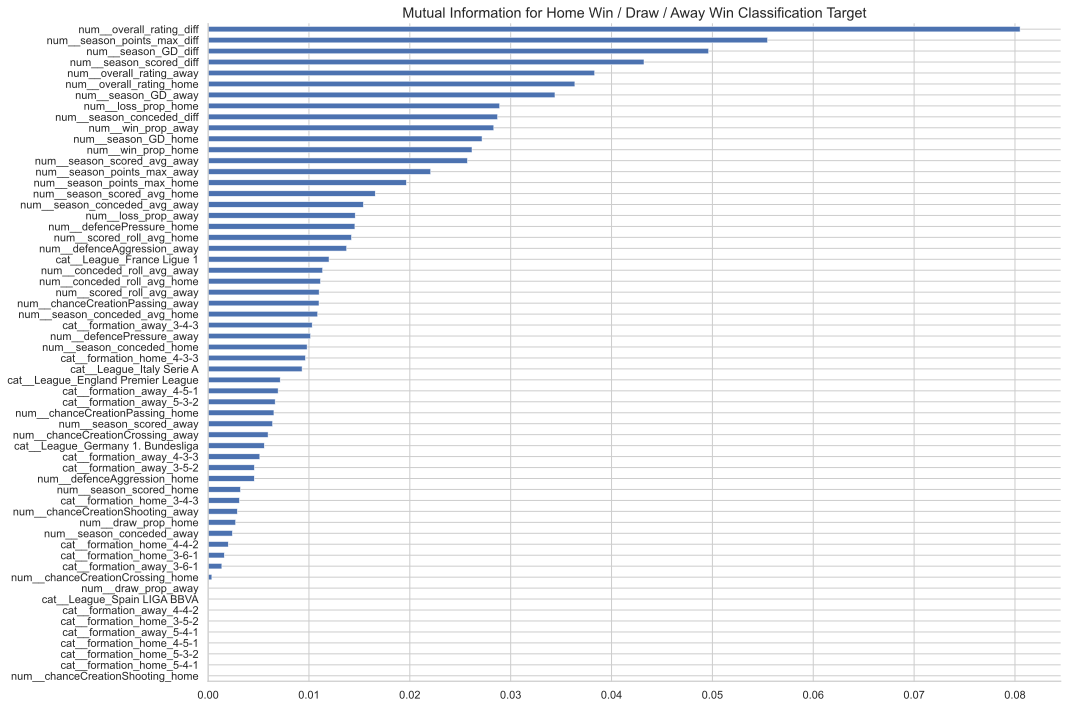

In [20]:
mi = mutual_info_classif(X_train_enc, Y_train_win, random_state=0)
mi = pd.Series(mi, index=X_train_enc.columns).sort_values(ascending=True)
mi.plot.barh(x=mi.index)
plt.title(
    "Mutual Information for Home Win / Draw / Away Win Classification Target"
)

plt.show()

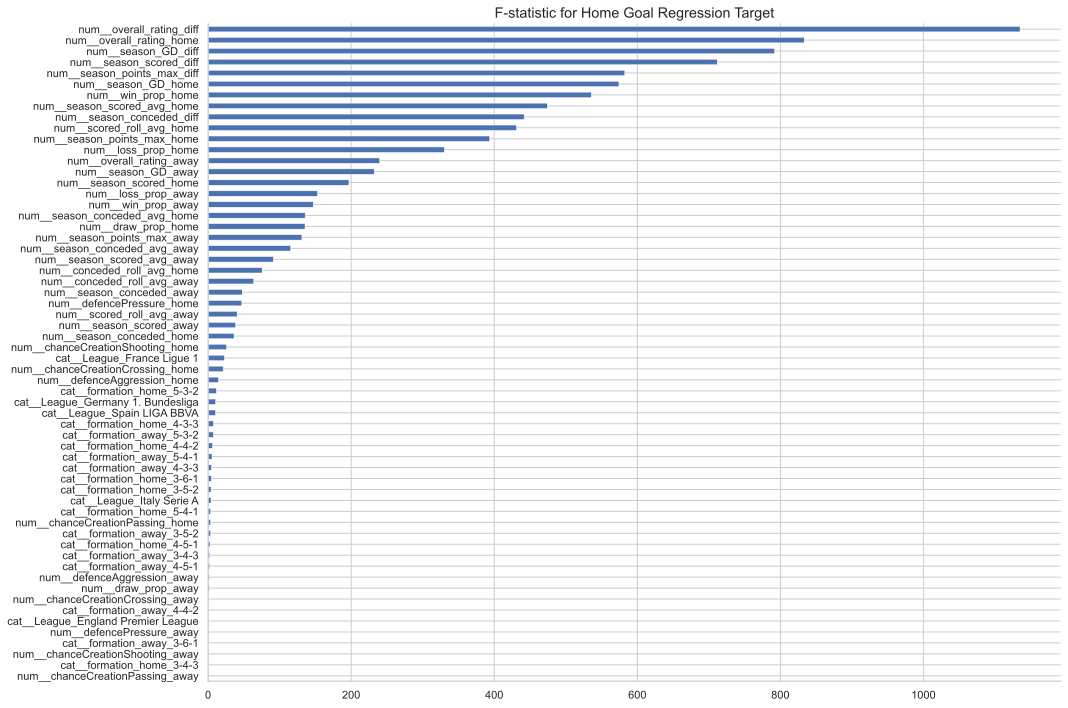

In [21]:
f, _ = f_regression(
    X_train_enc,
    Y_train_home_goal,
)
f_home_goal = pd.Series(f, index=X_train_enc.columns).sort_values(
    ascending=True
)
f_home_goal.plot.barh(x=mi.index)
plt.title("F-statistic for Home Goal Regression Target")
plt.show()

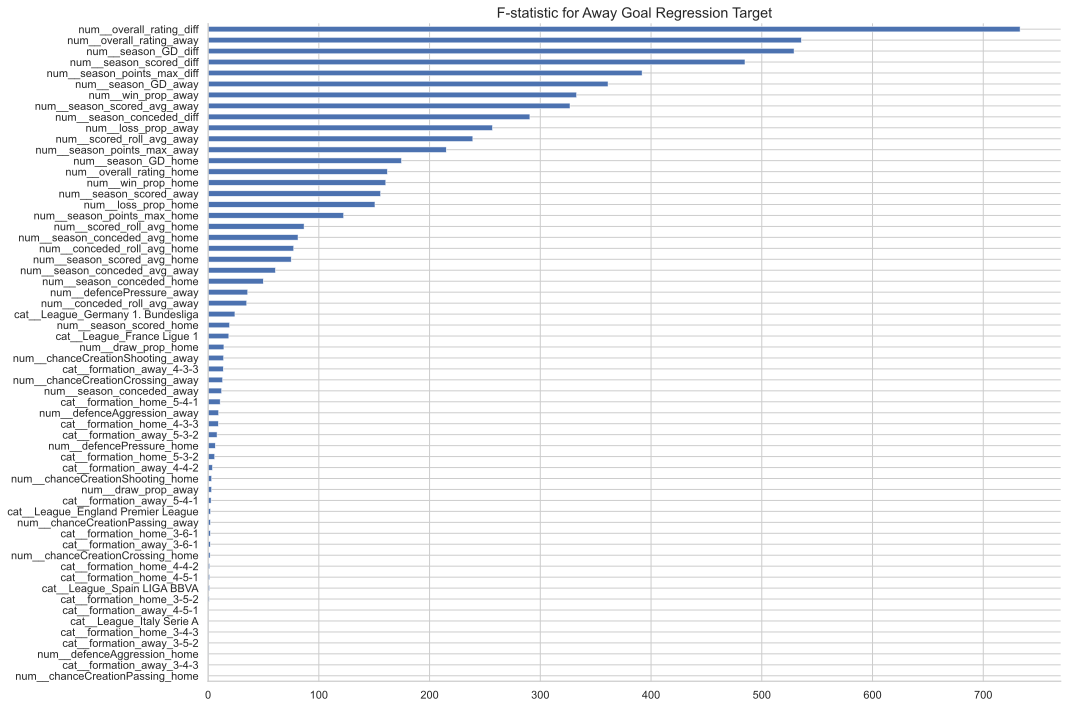

In [22]:
f, _ = f_regression(
    X_train_enc,
    Y_train_away_goal,
)
f_away_goal = pd.Series(f, index=X_train_enc.columns).sort_values(
    ascending=True
)
f_away_goal.plot.barh(x=mi.index)
plt.title("F-statistic for Away Goal Regression Target")
plt.show()

Features are ranked from highest to lowest by mutual information and f-statistic for each prediction task (higher is better) and mean correlation with other features (lower is better). In the heatmap below, the lower rank is better.

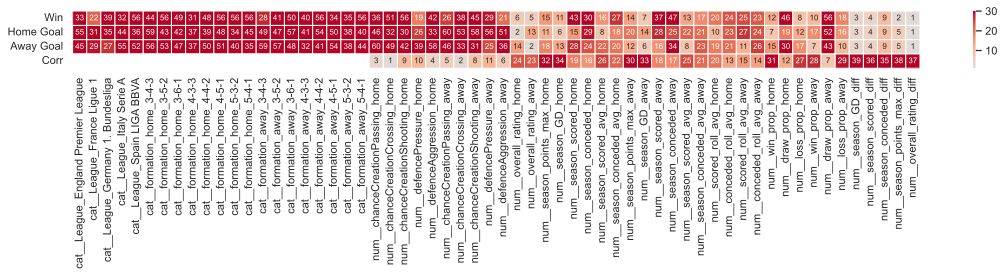

In [23]:
corr_rank = corr_matrix.abs().mean().rank().add_prefix("num__")
corr_rank.name = "Corr"
table = pd.DataFrame(index=X_train_enc.columns)
table["Win"] = mi.rank(ascending=False)
table["Home Goal"] = f_home_goal.rank(ascending=False)
table["Away Goal"] = f_away_goal.rank(ascending=False)
table = table.merge(corr_rank, how="left", left_index=True, right_index=True)
table

plt.figure(figsize=(16, 4))
sns.heatmap(
    table.T,
    annot=True,
    annot_kws={"size": 8},
    cmap="coolwarm",
    fmt=".0f",
    center=0,
    linewidths=1,
    vmin=1,
    vmax=30,
)
plt.yticks(rotation=0)
plt.grid(False)
plt.show()

Features are selected if they are in the top 10 rank by mutual information of f-statistic for either task and does not threaten to induce multicollinearity. Hence, the following features are selected. Formation feature is kept just for later analysis purpose.

In [24]:
match_small = match[
    [
        "League",
        "Season",
        "date",
        "home_goal",
        "away_goal",
        "Result",
        "formation_away",
        "formation_home",
        "overall_rating_home",
        "overall_rating_away",
        "overall_rating_diff",
        "season_GD_home",
        "season_GD_away",
        "season_scored_avg_home",
        "season_scored_avg_away",
        "win_prop_home",
        "win_prop_away",
        "loss_prop_home",
        "loss_prop_away",
        "season_points_max_diff",
        "season_scored_diff",
        "season_conceded_diff",
    ]
].copy()
match_small.rename(
    columns={"home_goal": "Home Goals", "away_goal": "Away Goals"},
    inplace=True,
)

Finally, the dataframe is saved to external file.

In [25]:
match_small.to_pickle("match.pkl")